# Monte Carlo Simulations

The noise present in quantum mechanical systems can be described semi-classically
by including random variables into Schroedinger's equation turning it
into a stochastic differential equation.

This equation can then be solved numerically with a Monte Carlo Method by
sampling the noise distribution and repeating the simulation for each noise
sample.
In the simulation we distinguish between the general case of fast noise with a real valued
spectral noise density $S(f)$ and approximately quasi static noise.
The latter describes the case where the spectral noise density is only larger
than zero at frequencies which are slower than the quantum
gate, i.e. $S(f) = 0 \; \forall f > 1/T$ where $T$ is the total gate time.

In the previous example of rabi driving, realistic experiments show some
instability in the resonance frequency. Let us
therefore assume that the resonance frequency of our system is time dependent
as has a mean value of $\omega_0$.

\begin{equation}
\omega(t) = \omega_0 + \delta_\omega (t)
\end{equation}

Then we consider the following Hamilton operator in the rotating wave
approximation:

\begin{equation}
H =  \delta_\omega (t) \sigma_z / 2 +  A_x (t) \sigma_x / 2
+  A_y(t) \sigma_y / 2
\end{equation}

## Quasi Static Noise

The noise realizations required for the Monte Carlo simulations are created
in the `NoiseTraceGenerator` classes. Let us consider the case of quasi static noise
first:



In [1]:
from qopt import *
import numpy as np
import matplotlib.pyplot as plt

ntg_quasi_static = NTGQuasiStatic(
    n_samples_per_trace=10,
    standard_deviation=[.5],
    n_traces=5,
    always_redraw_samples=False,
    sampling_mode='uncorrelated_deterministic'
)

The NTGQuasiStatic receives a standard deviation for each random variable. For
quasi static noise it is usually sufficient to sample only a few traces, while
many more are required to suppress the statistical uncertainties for general
noise spectral densities.

In the sampling mode `sampling_mode='uncorrelated_deterministic'` the noise is sampled
deterministically from a Gaussian distribution and each variable is sampled
separately. Hence, the number of noise traces which are returned are
n_traces times the number of random variables.

The other implemented sampling mode is monte_carlo, where the noise traces are
created with help of random number generators and all random variables are
sampled at once.

Next, we optimize the pulse subjected to quasi static noise. We begin with the
same setup as in the noiseless case:

In [2]:
sigma_x = DenseOperator.pauli_x()
sigma_y = DenseOperator.pauli_y()
sigma_z = DenseOperator.pauli_z()

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

n_time_steps = 10
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

But we use a different solver.

In [3]:
solver_qs_noise = SchroedingerSMonteCarlo(
    h_drift=h_drift * n_time_steps,
    h_ctrl=h_ctrl,
    h_noise=[sigma_z],
    initial_state=DenseOperator(np.eye(2)),
    noise_trace_generator=ntg_quasi_static,
    tau=time_steps
)

For the cost function, we have multiple options. We can use a cost function
which averages the entanglement infidelity
$F_e$ over the noise realizations to calculate the infidelity caused by noise
$_{n}F_e$:

\begin{equation}
_nF_e = \frac{1}{n_\text{traces}}\sum_{\delta_\omega} F
\end{equation}

This includes the stochastic (caused by noise) and the systematic (also
appearing in the absence of noise) deviations.
However, there are
certain advantages, if the stochastic and the systematic deviations are split.
It gives us a feeling for the cause of infidelities in our system, and the
optimization algorithms aquires the information, that it optimizes two cost
functions at once, if a vector valued optimization algorithm is chosen.

In [4]:
x_half = sigma_x.exp(np.pi * .25j)

entanglement_infidelity = OperationInfidelity(
    solver=solver_qs_noise,
    target=x_half
)

qs_noise_cost = OperationNoiseInfidelity(
    solver=solver_qs_noise,
    target=x_half,
    neglect_systematic_errors=True
)

We need to add the new solver and cost function to the simulator. We then also
increase the maximal wall time since the Monte Carlo simulation is numerically
more complex.

In [5]:
from qopt.simulator import Simulator
from qopt.optimize import LeastSquaresOptimizer
simulator = Simulator(
    solvers=[solver_qs_noise],
    cost_funcs=[entanglement_infidelity, qs_noise_cost]
)
# There are two cost functions connected to a single solver. We could also
# use a second solver only calculating the noiseless evolution, but this
# functionality is also included in the SchroedingerSMonteCarlo class.

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 120.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 1000,
    "min_amplitude_change": 1e-8
}

upper_bounds = 5 * 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

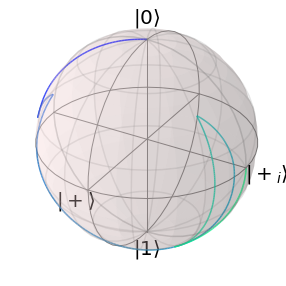

In [6]:
np.random.seed(0)
initial_pulse = np.pi * np.random.rand(n_time_steps, len(h_ctrl))

result = optimizer.run_optimization(initial_control_amplitudes=initial_pulse)
solver_qs_noise.set_optimization_parameters(result.final_parameters)
solver_qs_noise.plot_bloch_sphere()
plt.show()

The optimized pulses are not susceptible to quasi static noise. For
visualization, we can plot the cost functions during the optimization.

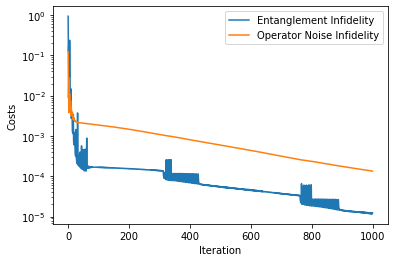

In [7]:
data_container = DataContainer(
    storage_path=r'..\..\..\temp',
    file_name="File Name"
)

data_container.append_optim_result(optim_result=result)
analyser = Analyser(data=data_container)
analyser.plot_costs()
plt.show()

## Fast Noise

To discuss the general case of arbitrary noise spectra, lets consider the
example of Johnson noise, which we directly apply to the control parameters.

The frequency range of the noise sampling is limited by the time
discretization. The lower limit is $f_{min} = 1/T$
where $T$ is the total time of the pulse, and the upper limit is given by
$f_{max} = 1 / \delta t$, where $\delta t$ is the spacing of the time steps. To
extend $f_{max}$ to higher values, we can use a simple transfer function, which
does nothing but oversampling the pulse.

In [8]:
oversampling = 100
def noise_spectral_density(f):
    return 1 / f

ntg_1_over_f = NTGColoredNoise(
    noise_spectral_density=noise_spectral_density,
    dt=time_steps[0] / oversampling,
    n_samples_per_trace=n_time_steps * oversampling,
    n_traces=100,
    n_noise_operators=2
)

oversampling_tf = OversamplingTF(
    oversampling=oversampling,
    num_ctrls=2
)
oversampling_tf.set_times(time_steps)

As we apply the noise directly to the optimization parameters we can use the
class SchroedingerSMControlNoise, which also automatically takes the amplitude
function into account, if any is given.

In [9]:
solver_1_over_f = SchroedingerSMCControlNoise(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    noise_trace_generator=ntg_1_over_f,
    tau=total_time / n_time_steps * np.ones(
        (n_time_steps, )
    ),
    transfer_function=oversampling_tf
)

cost_1_over_f = OperationNoiseInfidelity(
    solver=solver_1_over_f,
    target=None,
    neglect_systematic_errors=True
)

solver_1_over_f.set_optimization_parameters(result.final_parameters)
cost_1_over_f.costs()

0.09589564915442621